In [1]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import tensorflow as tf

print(tf.__version__)

2.3.0


In [3]:
import numpy as np
import matplotlib.pyplot as plt


def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
path_to_file = tf.keras.utils.get_file(
    "daily-min-temperatures.csv",
    "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv",
)

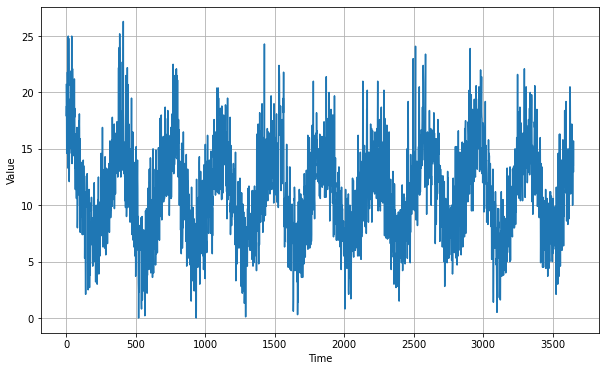

In [5]:
import csv

time_step = []
temps = []

with open(path_to_file) as csvfile:
    reader = csv.reader(csvfile, delimiter=",")
    next(reader)
    step = 0
    for row in reader:
        temps.append(float(row[1]))
        step += 1
        time_step.append(step)
# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc


series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [6]:
split_time = 2500
time_train = time[:split_time]  # YOUR CODE HERE
x_train = series[:split_time]  # YOUR CODE HERE
time_valid = time[split_time:]  # YOUR CODE HERE
x_valid = series[split_time:]  # YOUR CODE HERE

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [29]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer_size)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    ds = ds.batch(batch_size).prefetch(1)

    return ds

In [30]:
def model_forecast(model, series, window_size):
    # YOUR CODE HERE
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    predict = model.predict(ds)

    return predict

In [31]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Conv1D(
            filters=32,
            padding="causal",
            strides=1,
            kernel_size=5,
            activation="relu",
            input_shape=[None, 1],
        ),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1, activation="relu"),
        tf.keras.layers.Lambda(lambda x: x * 400),
    ]
)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10 ** (epoch / 20)
)
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 0s 16ms/step - loss: 9.7762 - mae: 10.2733
Epoch 2/100
10/10 [==============================] - 0s 20ms/step - loss: 9.7749 - mae: 10.2719
Epoch 3/100
10/10 [==============================] - 0s 19ms/step - loss: 9.7728 - mae: 10.2698
Epoch 4/100
10/10 [==============================] - 0s 20ms/step - loss: 9.7703 - mae: 10.2673
Epoch 5/100
10/10 [==============================] - 0s 19ms/step - loss: 9.7675 - mae: 10.2645
Epoch 6/100
10/10 [==============================] - 0s 19ms/step - loss: 9.7643 - mae: 10.2613
Epoch 7/100
10/10 [==============================] - 0s 18ms/step - loss: 9.7607 - mae: 10.2577
Epoch 8/100
10/10 [==============================] - 0s 19ms/step - loss: 9.7567 - mae: 10.2537
Epoch 9/100
10/10 [==============================] - 0s 18ms/step - loss: 9.7523 - mae: 10.2492
Epoch 10/100
10/10 [==============

(1e-08, 0.0001, 0.0, 60.0)

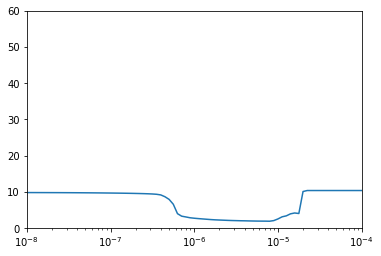

In [32]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [33]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(
    x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size
)
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Conv1D(
            filters=60,
            padding="causal",
            strides=1,
            kernel_size=5,
            activation="relu",
            input_shape=[None, 1],
        ),
        tf.keras.layers.LSTM(60, return_sequences=True),
        tf.keras.layers.LSTM(60, return_sequences=True),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1, activation="relu"),
        tf.keras.layers.Lambda(lambda x: x * 400),
    ]
)


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(train_set, epochs=159)

# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/159
25/25 [==============================] - 0s 10ms/step - loss: 7.9687 - mae: 8.4608
Epoch 2/159
25/25 [==============================] - 0s 10ms/step - loss: 3.7014 - mae: 4.1764
Epoch 3/159
25/25 [==============================] - 0s 10ms/step - loss: 2.2412 - mae: 2.7005
Epoch 4/159
25/25 [==============================] - 0s 10ms/step - loss: 2.1094 - mae: 2.5665
Epoch 5/159
25/25 [==============================] - 0s 10ms/step - loss: 1.9821 - mae: 2.4372
Epoch 6/159
25/25 [==============================] - 0s 10ms/step - loss: 1.9005 - mae: 2.3540
Epoch 7/159
25/25 [==============================] - 0s 10ms/step - loss: 1.8579 - mae: 2.3107
Epoch 8/159
25/25 [==============================] - 0s 10ms/step - loss: 1.8002 - mae: 2.2511
Epoch 9/159
25/25 [==============================] - 0s 10ms/step - loss: 1.7818 - mae: 2.2325
Epoch 10/159
25/25 [==============================] - 0s 10ms/step - loss: 1.7442 - mae: 2.1936
Epoch 11/159
25/25 [=============================

In [34]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size : -1, -1, 0]

TypeError: window() missing 1 required positional argument: 'size'

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.780626

In [ ]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[11.636601 10.97607  12.159701 ... 13.589686 13.726407 14.940471]
